In [49]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

FS, FREQ_LO, FREQ_HI = 1_000, 0.5, 100
MAT_FILE_PATH = (
    ".../filtered-point-process/"
    "filtered_point_process/Notebooks/Figure_Code_Bloniasz_et_al_2024/"
    "Figure_A_Blue.mat"
)


In [50]:
def load_empirical(mat_path):
    M     = scipy.io.loadmat(mat_path)
    freqs = M["frequencies"].squeeze()
    spec  = M["Spectrogram (Original)"]
    t     = M["time"].squeeze()

    PSD_A = spec[:, (t >= 45) & (t < 49)].mean(axis=1)
    PSD_I = spec[:, (t >= 35) & (t < 39)].mean(axis=1)
    PSD_W = M["Awake PSD"].squeeze()

    def mirror(f, s):
        return np.concatenate((-f[1:][::-1], f)), np.concatenate((s[1:][::-1], s))

    return mirror(freqs, PSD_A), mirror(freqs, PSD_I), mirror(freqs, PSD_W)

(EXT_F_A, EXT_PSD_A), (EXT_F_I, EXT_PSD_I), (EXT_F_W, EXT_PSD_W) = load_empirical(MAT_FILE_PATH)


In [51]:
PARAMS_less = dict(
    # slow-wave & alpha peaks
    cf_sw        = 0.8,
    bw_sw        = 0.5,
    cf_al_A      = 17.0,
    bw_al_A      = 1.0,
    cf_al_W      = 13.0,
    bw_al_W      = 2.5,

    # Anaesthetised rhythm heights
    amp_G_A      = 1.0,
    amp_A_A      = 1.0,

    # Anaesthetised base-rates
    λ_G_A        = 1533631.2009744726,
    λ_A_A        = 17_556_431_977.538925,

    # Anaesthetised synaptic weights
    w_G_A_slow   = 20_175.908147879563,
    w_G_A_alpha  = 48_428.22049383736,
    w_A_A_slow   = 635_728.5342626794,
    w_A_A_alpha  = 24_044.21123481236,

    # Infusion base-rates & zero rhythms
    λ_G_I        = 25379221.95935626,
    λ_A_I        = 421801933.68733984,
    w_G_I_slow   = 0.0,
    w_G_I_alpha  = 0.0,
    w_A_I_slow   = 0.0,
    w_A_I_alpha  = 0.0,

    # Awake rhythm height
    amp_A_W      = 1.0,

    # Awake base-rates & weights
    λ_G_W        = 413_380.94387958397,
    λ_A_W        = 19_144_542_803.938618,
    w_G_W_slow   = 0.0,
    w_G_W_alpha  = 38124.50149917748,
    w_A_W_slow   = 0.0,
    w_A_W_alpha  = 39051.42142218129,

    # Global 1/f filter
    A_1f         = 18.686141856364625,

    # Shared kinetics (A & W)
    τr_A         = 0.5350833367285446,
    τd_A         = 2.2538970551811874,
    τr_G         = 0.598138406187622,
    τd_G         = 11.000661108306533,

    # Infusion-specific kinetics
    τr_A_I       = 0.049999999999999996,
    τd_A_I       = 2.0,
    τr_G_I       = 0.05343151083548018,
    τd_G_I       = 13.999999999999998,
)


In [52]:
def _fp_process(
    *,
    f0_peaks: list[float],
    bw_peaks: list[float],
    GABA_rate: float,
    AMPA_rate: float,
    w_GABA_slow: float,
    w_GABA_alpha: float,
    w_AMPA_slow: float,
    w_AMPA_alpha: float,
    tau_rise_AMPA: float,
    tau_decay_AMPA: float,
    tau_rise_GABA: float,
    tau_decay_GABA: float,
    A_filter: float,
):
    # always unit-height bumps
    cif_pars = [
        {
            "peak_height":      [1.0, 1.0],
            "center_frequency": f0_peaks,
            "peak_width":       bw_peaks,
            "lambda_0":         GABA_rate,
        },
        {
            "peak_height":      [1.0, 1.0],
            "center_frequency": f0_peaks,
            "peak_width":       bw_peaks,
            "lambda_0":         AMPA_rate,
        },
    ]
    mdl = Model(
        "multivariate_gaussian",
        {"num_processes": 2, "cif_types": ["Gaussian"]*2, "cif_params": cif_pars},
        dict(
            fs=FS,
            simulate=False,
            seed=5,
            dependence="dependent",
            weights=[
                [w_GABA_slow,  w_GABA_alpha],
                [w_AMPA_slow,  w_AMPA_alpha],
            ],
        ),
    )

    filters = {"filter_1": "GABA", "filter_2": "AMPA", "filter_3": "1/f"}
    fpar = {
        "filter_1": {"tau_rise": tau_rise_GABA/1e3, "tau_decay": tau_decay_GABA/1e3},
        "filter_2": {"tau_rise": tau_rise_AMPA/1e3, "tau_decay": tau_decay_AMPA/1e3},
        "filter_3": {"A": A_filter},
    }
    fpp = FilteredPointProcess(model=mdl, filters=filters, filter_params=fpar)
    fpp.apply_filter_sequences([["filter_1","filter_2","filter_3"]])
    return fpp

# ───────── _spec with two independent bumps ─────────
def _spec(code: str, p: dict):
    if code == "A":
        f0_peaks = [p["cf_sw"],    p["cf_al_A"]]
        bw_peaks = [p["bw_sw"],    p["bw_al_A"]]
        rates    = (p["λ_G_A"],    p["λ_A_A"])
        weights  = (p["w_G_A_slow"], p["w_G_A_alpha"],
                    p["w_A_A_slow"], p["w_A_A_alpha"])
        kinetics = (p["τr_A"], p["τd_A"], p["τr_G"], p["τd_G"])

    elif code == "W":
        # no slow-wave; only alpha bump
        f0_peaks = [0.0,          p["cf_al_W"]]
        bw_peaks = [0.0,          p["bw_al_W"]]
        rates    = (p["λ_G_W"],   p["λ_A_W"])
        weights  = (p["w_G_W_slow"], p["w_G_W_alpha"],
                    p["w_A_W_slow"], p["w_A_W_alpha"])
        kinetics = (p["τr_A"], p["τd_A"], p["τr_G"], p["τd_G"])

    else:  # Infusion
        # no rhythms at all (showing for completeness, refactor function for this)
        f0_peaks = [0.0, 0.0]
        bw_peaks = [0.0, 0.0]
        rates    = (p["λ_G_I"], p["λ_A_I"])
        weights  = (p["w_G_I_slow"], p["w_G_I_alpha"],
                    p["w_A_I_slow"], p["w_A_I_alpha"])
        kinetics = (p["τr_A_I"], p["τd_A_I"], p["τr_G_I"], p["τd_G_I"])

    GABA_rate, AMPA_rate = rates
    wG_slow, wG_alpha, wA_slow, wA_alpha = weights
    τr_A, τd_A, τr_G, τd_G           = kinetics

    fpp = _fp_process(
        f0_peaks=f0_peaks,
        bw_peaks=bw_peaks,
        GABA_rate=GABA_rate,
        AMPA_rate=AMPA_rate,
        w_GABA_slow=wG_slow,
        w_GABA_alpha=wG_alpha,
        w_AMPA_slow=wA_slow,
        w_AMPA_alpha=wA_alpha,
        tau_rise_AMPA=τr_A,
        tau_decay_AMPA=τd_A,
        tau_rise_GABA=τr_G,
        tau_decay_GABA=τd_G,
        A_filter=p["A_1f"],
    )
    return fpp.frequencies, fpp.final_spectrum, fpp


In [53]:
def _draw(ax, fpp, freqs_ext, psd_ext):
    """
    Legacy-style spectrum plotting on a given Axes.
    - ax: matplotlib Axes
    - fpp: FilteredPointProcess instance
    - freqs_ext, psd_ext: empirical (mirrored) frequency & power arrays
    """
    dec = fpp.decompositions
    λg, λa = dec[0]["lambda_only"], dec[1]["lambda_only"]
    fg = fpp.filter_instances["filter_1"].kernel_spectrum
    fa = fpp.filter_instances["filter_2"].kernel_spectrum
    f1 = fpp.filter_instances["filter_3"].kernel_spectrum

    ax.loglog(freqs_ext, psd_ext,
              color="grey",   linewidth=4, label="Empirical Spectrum")
    ax.loglog(fpp.frequencies,
              fpp.final_spectrum,
              color="black",  linewidth=4, label="Theoretical Model Spectrum")

    ax.loglog(fpp.frequencies, λa * fa * f1,
              color="red",    linestyle="--", linewidth=2, label="AMPA Broadband")
    ax.loglog(fpp.frequencies, λg * fg * f1,
              color="blue",   linestyle="--", linewidth=2, label="GABA Broadband")

    ax.loglog(fpp.frequencies, dec[1]["cif"] * fa * f1,
              color="red",    linestyle="-",  linewidth=2, label="AMPA Rhythm")
    ax.loglog(fpp.frequencies, dec[0]["cif"] * fg * f1,
              color="blue",   linestyle="-",  linewidth=2, label="GABA Rhythm")

    ax.set_xlim(FREQ_LO, FREQ_HI)
    ax.set_ylim(1e-2, 1e4)
    ax.set_yticks([1e-2, 1e0, 1e2, 1e4])
    ax.tick_params(axis="both", which="major", labelsize=35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/cif/Spectral_Gaussian.py:81: RuntimeWarning: divide by zero encountered in divide
  * np.exp(-((f - center) ** 2) / (2 * width**2))
/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/cif/Spectral_Gaussian.py:81: RuntimeWarning: invalid value encountered in divide
  * np.exp(-((f - center) ** 2) / (2 * width**2))
/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/cif/Spectral_Gaussian.py:82: RuntimeWarning: divide by zero encountered in divide
  + height * np.exp(-((f + center) ** 2) / (2 * width**2))
/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/cif/Spectral_Gaussian.py:82: RuntimeWarning: invalid value encountered in divide
  + height * np.exp(-((f + center) ** 2) / (2 * width**2))


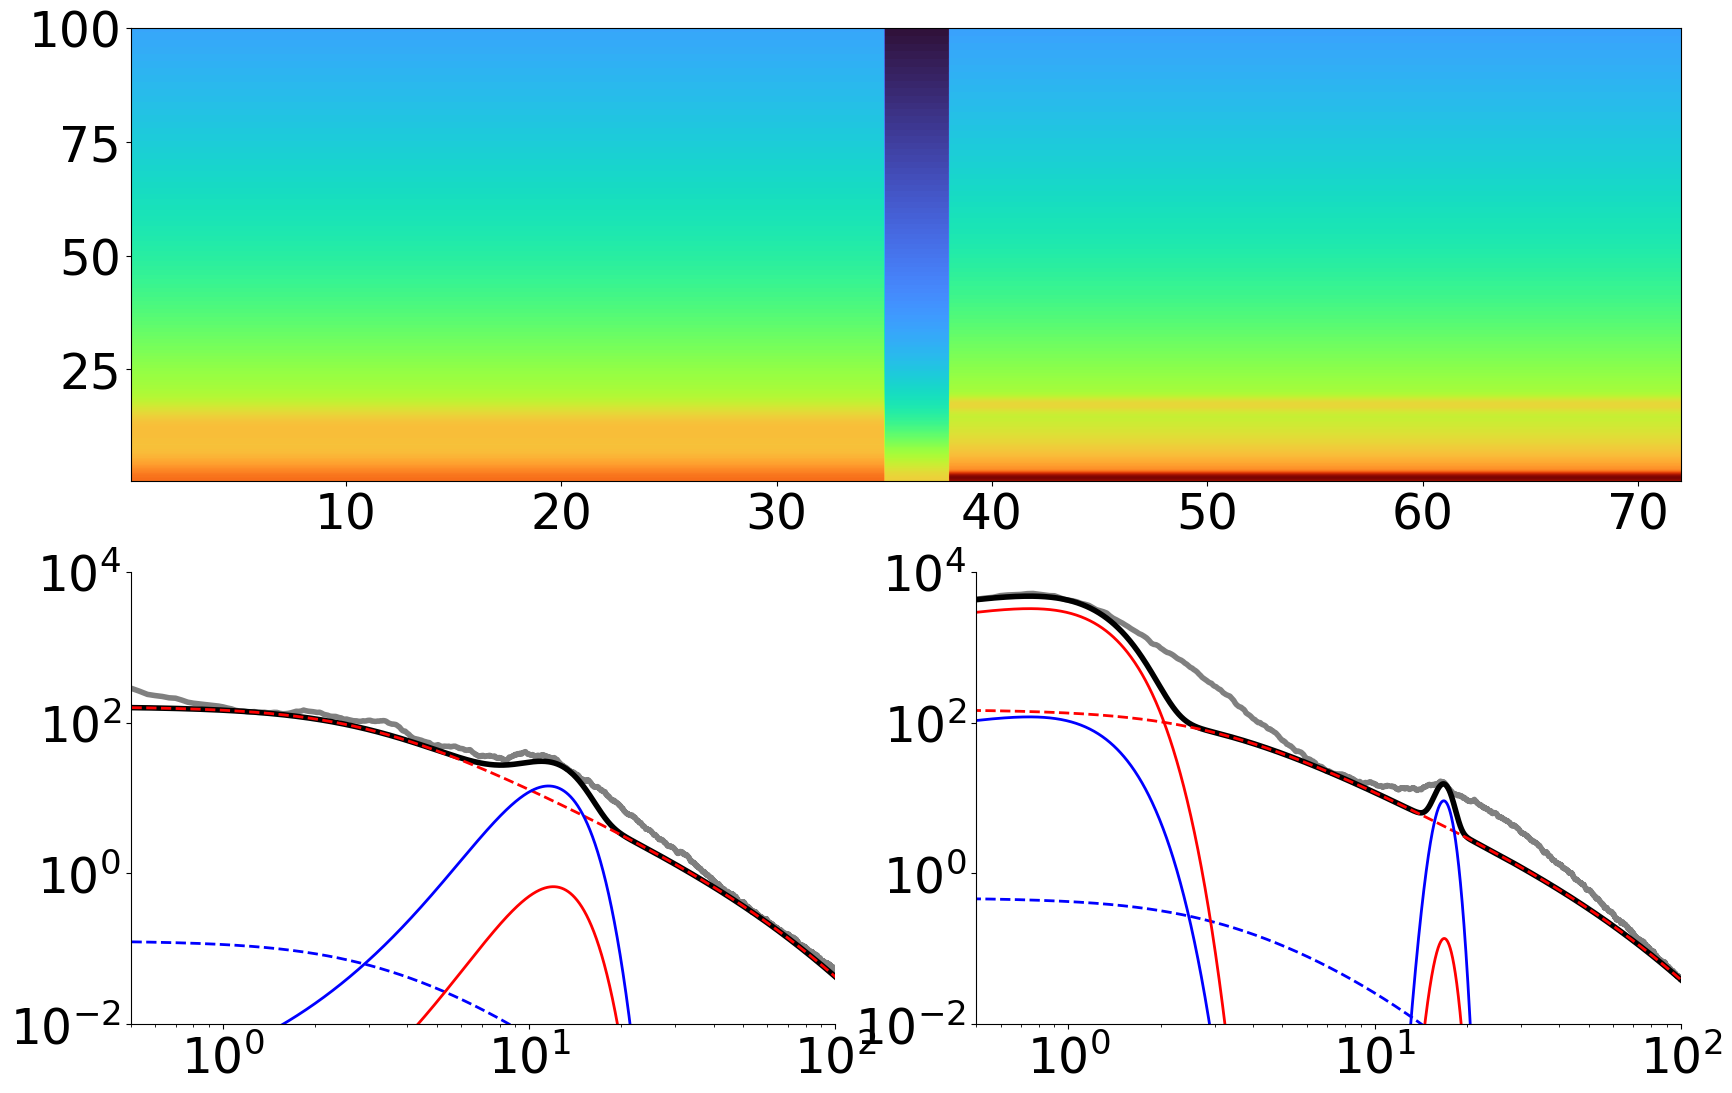

In [54]:
fA, specA, FPP_A = _spec("A", PARAMS_less)
fW, specW, FPP_W = _spec("W", PARAMS_less)
fI, specI, FPP_I = _spec("I", PARAMS_less)

# 1) Build time axis
dur_A, dur_I, dur_W = 34, 3, 35
sec_A, sec_I, sec_W = [d * 60 for d in (dur_A, dur_I, dur_W)]
tA = np.linspace(0, dur_W, sec_W)
tI = np.linspace(dur_W, dur_W + dur_I, sec_I)
tB = np.linspace(dur_W + dur_I, dur_W + dur_I + dur_A, sec_A)
T  = np.concatenate([tA, tI, tB])

fmask   = (FPP_A.frequencies >= 0) & (FPP_A.frequencies <= 100)
specW_l = np.log10(np.abs(FPP_W.final_spectrum[fmask] / (1/FS**2)))
specI_l = np.log10(np.abs(FPP_I.final_spectrum[fmask] / (1/FS**2)))
specA_l = np.log10(np.abs(FPP_A.final_spectrum[fmask] / (1/FS**2)))
combo   = np.concatenate([
    np.tile(specW_l[:, None], (1, len(tA))),
    np.tile(specI_l[:, None], (1, len(tI))),
    np.tile(specA_l[:, None], (1, len(tB))),
], axis=1)

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3, 1, 1)
ax1.imshow(
    combo,
    aspect="auto",
    extent=[T.min(), T.max(), FREQ_LO, FREQ_HI],
    origin="lower",
    cmap="turbo",
)
ax1.set_xticks([10, 20, 30, 40, 50, 60, 70])
ax1.set_yticks([25, 50, 75, 100])
ax1.tick_params(axis="both", labelsize=35)

# 3b) Bottom-left: Awake (row 3, col 1 spans subplot index 3 in a 3×2 grid)
ax2 = fig.add_subplot(3, 2, 3)
_draw(ax2, FPP_W, EXT_F_W, EXT_PSD_W)
ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
ax2.tick_params(axis="y", labelsize=35)

# 3c) Bottom-right: Anaesthetised (row 3, col 2, subplot index 4)
ax3 = fig.add_subplot(3, 2, 4)
_draw(ax3, FPP_A, EXT_F_A, EXT_PSD_A)
ax3.set_yticks([1e-2, 1e0, 1e2, 1e4])
ax3.tick_params(axis="y", labelsize=35)


from pathlib import Path

SAVE_DIR = Path(".../filtered-point-process/filtered_point_process/Notebooks/Figure_Code_Bloniasz_et_al_2024/")
plt.savefig(SAVE_DIR / "composite_theoretical_figure_final_new.svg", bbox_inches="tight", format="svg")


plt.show()


In [55]:
import numpy as np
import numdifftools as nd  # for Derivative


def log_log_slope(f, spectrum, freq_vec):
    idx = np.argmin(np.abs(freq_vec - f))
    d_log_spectrum = nd.Derivative(
        lambda log_f: np.log10(
            spectrum[np.argmin(np.abs(freq_vec - 10**log_f))]
        )
    )
    return d_log_spectrum(np.log10(freq_vec[idx]))
    
def _draw_slope(ax, fpp, freqs_ext, psd_ext):
    dec = fpp.decompositions
    λg, λa = dec[0]["lambda_only"], dec[1]["lambda_only"]
    fg = fpp.filter_instances["filter_1"].kernel_spectrum
    fa = fpp.filter_instances["filter_2"].kernel_spectrum
    f1 = fpp.filter_instances["filter_3"].kernel_spectrum
    ax.loglog(freqs_ext, psd_ext,
              color="grey",   linewidth=4, label="Empirical Spectrum")
    ax.loglog(fpp.frequencies,
              fpp.final_spectrum,
              color="black",  linewidth=4, label="Theoretical Model Spectrum")
    ax.loglog(fpp.frequencies, λa * fa * f1,
              color="red",    linestyle="--", linewidth=2, label="AMPA Broadband")
    ax.loglog(fpp.frequencies, λg * fg * f1,
              color="blue",   linestyle="--", linewidth=2, label="GABA Broadband")
    ax.loglog(fpp.frequencies, dec[1]["cif"] * fa * f1,
              color="red",    linestyle="-",  linewidth=2, label="AMPA Rhythm")
    ax.loglog(fpp.frequencies, dec[0]["cif"] * fg * f1,
              color="blue",   linestyle="-",  linewidth=2, label="GABA Rhythm")

    model_psd = fpp.final_spectrum 

    # find the 50 Hz indices & plot red dots
    idx_emp = np.argmin(np.abs(freqs_ext    - 50.))
    idx_th  = np.argmin(np.abs(fpp.frequencies - 50.))
    f_emp, p_emp = freqs_ext[idx_emp],    psd_ext[idx_emp]
    f_th,  p_th  = fpp.frequencies[idx_th], model_psd[idx_th]

    ax.plot([f_emp, f_th], [p_emp, p_th], 'o', color='red', markersize=8)

    # compute slopes
    slope_emp = log_log_slope(50, psd_ext,   freqs_ext)
    slope_th  = log_log_slope(50, model_psd, fpp.frequencies)

    ax.set_xlim(FREQ_LO, FREQ_HI)
    ax.set_ylim(1e-2,  1e4)
    ax.set_yticks([1e-2, 1e0, 1e2, 1e4])
    ax.tick_params(axis="both", which="major", labelsize=35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    txt = (
        f"Empirical slope: {slope_emp:.2f}\n"
        f"Theoretical slope: {slope_th:.2f}"
    )
    ax.text(
        0.6, 0.3, txt,
        transform = ax.transAxes,        
        fontsize  = 15,
        ha        = "left",
        va        = "bottom",
        bbox      = dict(facecolor="white", alpha=0.7, edgecolor="none"),
        clip_on   = True,                # clip if anything bleeds outside
    )

In [56]:
# Second parameter set for “overall fit”
PARAMS_overall_fit = dict(
    # slow-wave & alpha peaks
    cf_sw        = 0.8,
    bw_sw        = 0.5,
    cf_al_A      = 17.0,
    bw_al_A      = 1.0,
    cf_al_W      = 13.0,
    bw_al_W      = 2.5,

    # Anaesthetised rhythm heights
    amp_G_A      = 1.0,
    amp_A_A      = 1.0,

    # Anaesthetised base-rates
    λ_G_A        = 294084305.00737506,
    λ_A_A        = 11732036765.173193,

    # Anaesthetised synaptic weights
    w_G_A_slow   = 105989.90657400139,
    w_G_A_alpha  = 13899.83289225461,
    w_A_A_slow   = 14223.443640360185,
    w_A_A_alpha  = 11385.24879595319,

    # Infusion base-rates & zero rhythms
    λ_G_I        = 289823835.1124805,
    λ_A_I        = 338726474.70930785,
    w_G_I_slow   = 0.0,
    w_G_I_alpha  = 0.0,
    w_A_I_slow   = 0.0,
    w_A_I_alpha  = 0.0,

    # Awake rhythm height
    amp_A_W      = 1.0,

    # Awake base-rates & weights
    λ_G_W        = 390492.8387550051,
    λ_A_W        = 9137614477.47125,
    w_G_W_slow   = 0.0,
    w_G_W_alpha  = 36752.68562770601,
    w_A_W_slow   = 0.0,
    w_A_W_alpha  = 12047.608329555223,

    # Global 1/f filter
    A_1f         = 20.471349809232954,

    # Shared kinetics (A & W)
    τr_A         = 0.05407835565927344,
    τd_A         = 3.139418961956667,
    τr_G         = 0.05734932826609837,
    τd_G         = 13.999999999999998,

    # Infusion-specific kinetics
    τr_A_I       = 0.049999999999999996,
    τd_A_I       = 2.0,
    τr_G_I       = 0.049999999999999996,
    τd_G_I       = 13.999999999999998,
)


In [57]:
# ─── 2) Instantiate the two Anaesthetised models ────────────
_, _, FPP_A_less    = _spec("A", PARAMS_less)
_, _, FPP_A_overall = _spec("A", PARAMS_overall_fit)



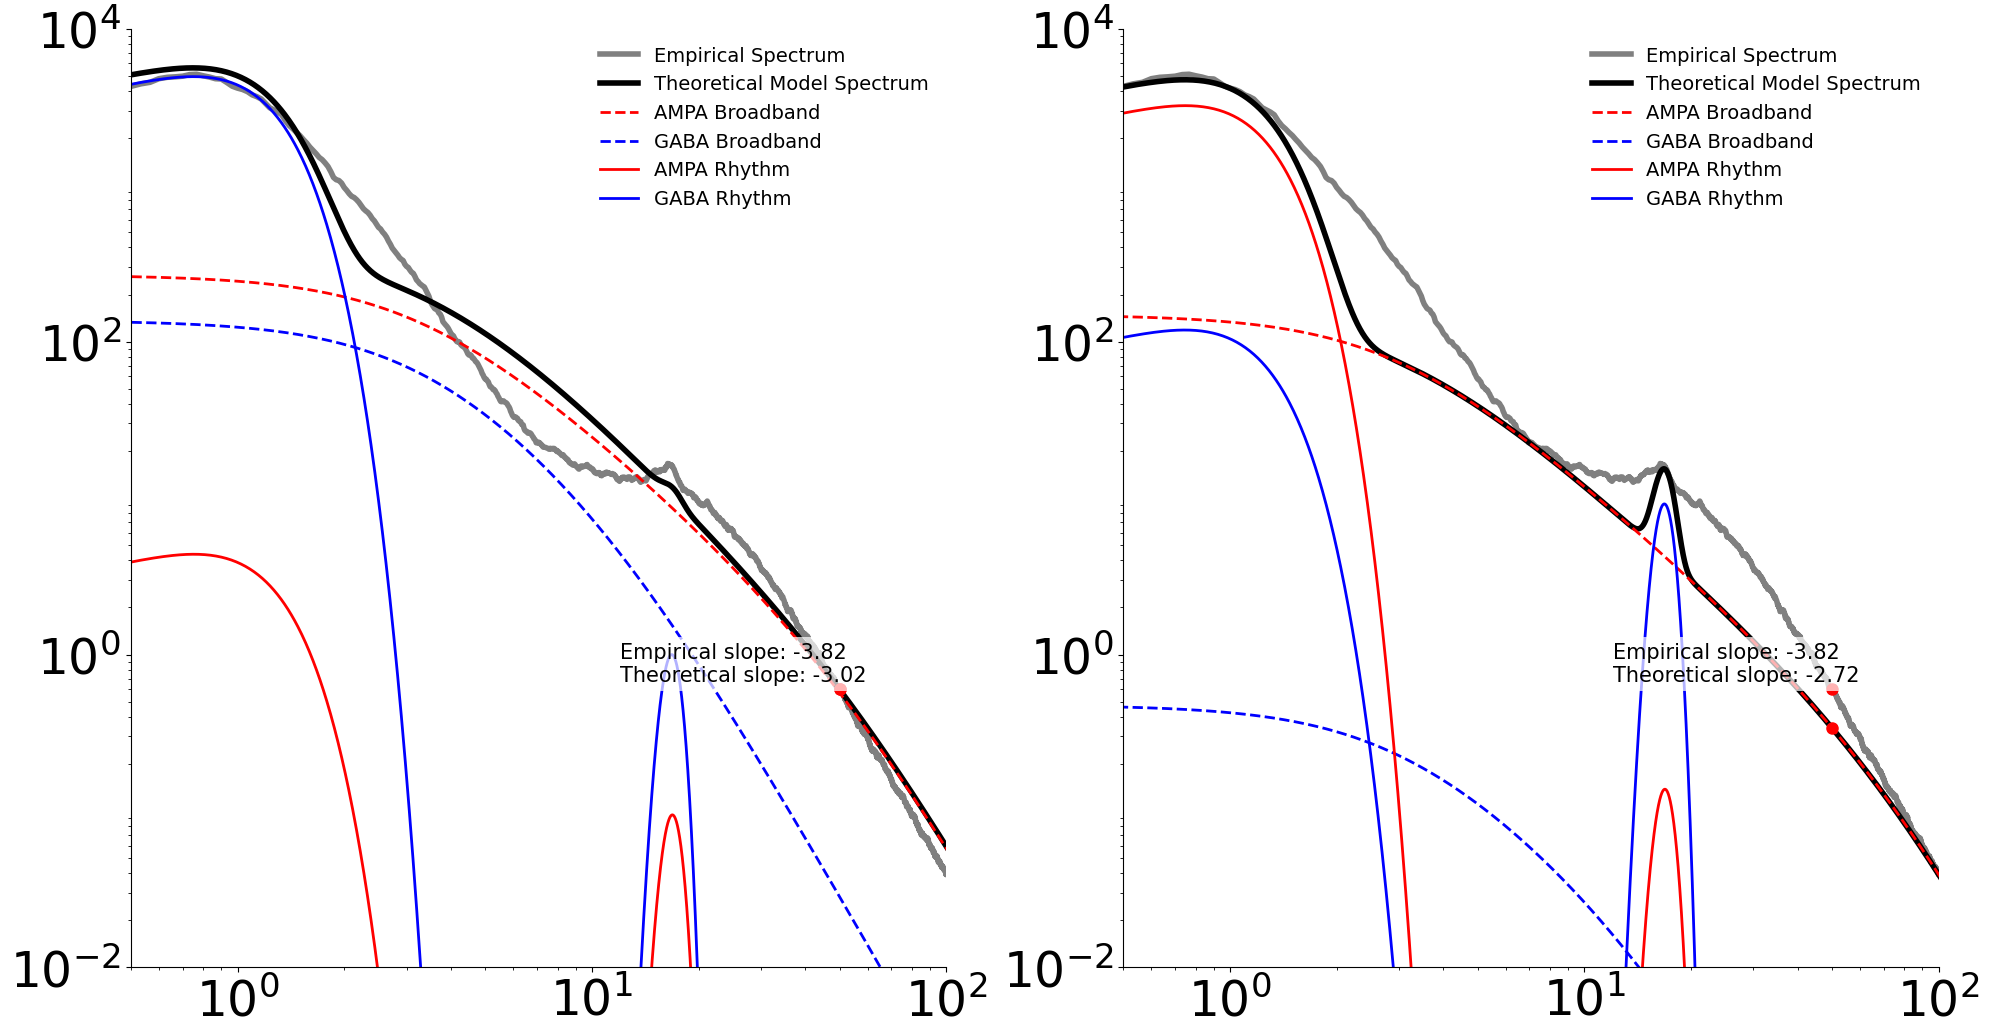

In [58]:
# 3) Plot side-by-side
fig = plt.figure(figsize=(20, 20))

# Left: “Overall fit”
axL = fig.add_subplot(2, 2, 1)
_draw_slope(axL, FPP_A_overall, EXT_F_A, EXT_PSD_A)
axL.set_yticks([1e-2, 1e0, 1e2, 1e4])
axL.tick_params(axis="y", labelsize=35)
axL.legend(fontsize=14, loc="upper right", frameon=False)

# Right: “Less than empirical”
axR = fig.add_subplot(2, 2, 2)
_draw_slope(axR, FPP_A_less, EXT_F_A, EXT_PSD_A)
axR.set_yticks([1e-2, 1e0, 1e2, 1e4])
axR.tick_params(axis="y", labelsize=35)
axR.legend(fontsize=14, loc="upper right", frameon=False)

SAVE_DIR = Path(".../filtered-point-process/filtered_point_process/Notebooks/Figure_Code_Bloniasz_et_al_2024/")
plt.savefig(SAVE_DIR / "Figure_6_new.svg", bbox_inches="tight", format="svg")


plt.tight_layout()
plt.show()